# 

In [1]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import tensorflow.keras as ks

#unsupervised:
from sklearn.cluster import KMeans
#transformers:
from sklearn.preprocessing import OneHotEncoder, TargetEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import scipy.stats as st

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#Note: train data has 13 feature column and 1 binary label for a total of 14 columns

In [2]:
train = pd.read_csv("train.csv")

In [3]:
train.head(4)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0


In [4]:
train.shape

(165034, 14)

In [5]:
# Kmeans cluster creditscore:
kk = KMeans(n_clusters = 2, n_init = 10)
cc = train.CreditScore.values
kk.fit(cc.reshape(-1,1))

KMeans(n_clusters=2, n_init=10)

In [6]:
# The below shows there are no correlation on the Exited if we cluster the data into 2
st.pearsonr(kk.labels_, train.Exited)

PearsonRResult(statistic=-0.034839070391925686, pvalue=1.6822965654293098e-45)

In [7]:
# Perform t-test:
a = train.CreditScore.loc[train.Exited == 0]
b = train.CreditScore.loc[train.Exited == 1]
# The below t-test is significant but since the sample size is large, there is no distinction at all as 
# shown in the next boxplot. That is why the KMeans can't cluster.
st.ttest_ind(a,b)

TtestResult(statistic=11.128116005299207, pvalue=9.373557251570065e-29, df=165032.0)

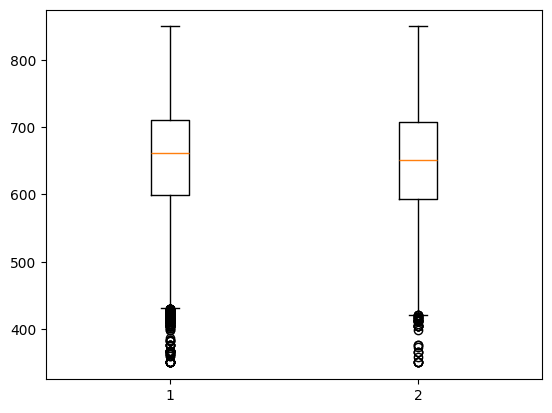

In [8]:
# See boxplot:
plt.boxplot([a, b])
plt.show()
# Below shows that we can't discriminate based on credit score. D

## **Conclusion**
Do not include? 

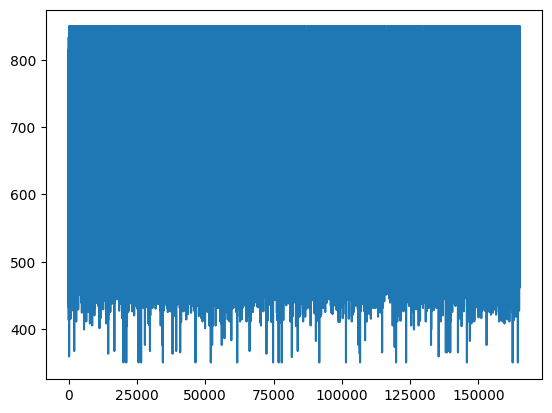

In [9]:
plt.plot(train.CreditScore)

In [10]:
z = pd.merge(pd.cut(train.CreditScore, bins = 6), train.Exited, left_index = True,
             right_index = True)

In [11]:
contingency = pd.crosstab(index = z.CreditScore,
                          columns = z.Exited)
contingency

Exited,0,1
CreditScore,,
"(349.5, 433.333]",270,85
"(433.333, 516.667]",5176,1424
"(516.667, 600.0]",27768,8388
"(600.0, 683.333]",46754,12557
"(683.333, 766.667]",40283,10042
"(766.667, 850.0]",9862,2425


In [12]:
result = st.chi2_contingency(contingency)
print("statistic = {}, p_value = {}".format(result.statistic, result.pvalue))

statistic = 151.26705611492767, p_value = 7.17456808034613e-31


In [13]:
class CreditScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.targetEncoder = TargetEncoder()
        self.bins = [0,475, 600, 725, 1000]

    def fit(self, X, y):
        a = pd.cut(X.CreditScore, bins = self.bins)
        b = np.array(a).reshape(-1,1)
        c = self.targetEncoder.fit(b,y)
        return self

    def transform(self,X):
        a = pd.cut(X.CreditScore, bins = self.bins)
        b = np.array(a).reshape(-1,1)
        c = self.targetEncoder.transform(b)
        return c
        


    

In [14]:
s = CreditScoreTransformer()
s.fit_transform(train,train.Exited)

array([[0.20388539],
       [0.20388539],
       [0.20388539],
       ...,
       [0.2296183 ],
       [0.2296183 ],
       [0.20927216]])

In [19]:
#optimizer
#optimize the binning
def cutOptimizer(colname, dataframe, max_bin = 12):
    output = []
    print("chi-square stat, independence test for {} and Exited variables".format(colname))
    for i in range(2,max_bin):
        v = pd.cut(dataframe[colname], bins = i)
        v1 = pd.merge(v,dataframe.Exited, left_index = True, right_index = True)
        v2 = pd.crosstab(v1[colname], v1.Exited)
        result = st.chi2_contingency(v2)
        output.append({"n_bins": i, "stat": result.statistic, "p_value": result.pvalue})
    return pd.DataFrame(output)

In [20]:
output = cutOptimizer(colname="CreditScore", dataframe=train, max_bin = 15)

chi-square stat, independence test for CreditScore and Exited variables


In [22]:
#Based on the below, use bins = 12
output.sort_values(by='stat', ascending = False)

,n_bins,stat,p_value
10,12,311.353147,3.542628e-60
11,13,310.970067,2.328469e-59
12,14,258.247040,1.237167e-47
9,11,254.265021,6.880794e-49
8,10,241.905743,5.093215e-47
6,8,239.071255,5.856056e-48
3,5,224.947771,1.614761e-47
7,9,220.754240,2.667892e-43
5,7,174.417794,5.196462e-35
4,6,151.267056,7.174568e-31


In [23]:

v = pd.cut(train['CreditScore'], bins = 12)

In [24]:
np.unique(v)

array([Interval(349.5, 391.667, closed='right'),
       Interval(391.667, 433.333, closed='right'),
       Interval(433.333, 475.0, closed='right'),
       Interval(475.0, 516.667, closed='right'),
       Interval(516.667, 558.333, closed='right'),
       Interval(558.333, 600.0, closed='right'),
       Interval(600.0, 641.667, closed='right'),
       Interval(641.667, 683.333, closed='right'),
       Interval(683.333, 725.0, closed='right'),
       Interval(725.0, 766.667, closed='right'),
       Interval(766.667, 808.333, closed='right'),
       Interval(808.333, 850.0, closed='right')], dtype=object)

In [25]:
class CreditScoreTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.targetEncoder = TargetEncoder()
        self.bins = [0,391.5, 433.5, 475.5, 516.5, 558.5,
                    600.5, 641.5, 683.5, 725.5, 766.5, 808.5,1000]

    def fit(self, X, y):
        a = pd.cut(X.CreditScore, bins = self.bins)
        b = np.array(a).reshape(-1,1)
        c = self.targetEncoder.fit(b,y)
        return self

    def transform(self,X):
        a = pd.cut(X.CreditScore, bins = self.bins)
        b = np.array(a).reshape(-1,1)
        c = self.targetEncoder.transform(b)
        return c
        